I've been getting into the Julia ecosystem a little (turns out there's a lot of tutorials you get to watch when doing the dishes), and I've been meaning to get some hands on experience. Today, I'd like to reproduce [Mosè Giordano](https://github.com/giordano)'s [gist example](https://gist.github.com/giordano/e82a3959d8f64301129d64d004e10b4e), which I first saw in this [JuliaCon talk by Stefan Karpinski](https://youtu.be/kc9HwsxE1OY?t=227). I think it really illustrates [Alan Edelman's points on Julia's composability from the talk I linked last time](https://www.youtube.com/watch?v=fGgLrzalESY).

What we'll do today is combine a simple example of an ODE solution with an uncertainty package, and see how easy or difficult it becomes using Julia.

<!--TEASER_END-->

# Differential equations

Let's try to use Julia's [DifferentialEquations.jl](https://github.com/SciML/DifferentialEquations.jl) package to solve the simple system:

$$\frac{du}{dt} = \alpha u$$

In [1]:
using DifferentialEquations

α = 1.01
u0 = 1/2             # initial value
tspan = (0.0, 1.0)   # range of values

(0.0, 1.0)

Simple enough! Let's define the derivative function. Note that it seems like the derivative's signature as accepted by `DifferentialEquations.ODEProblem` has changed since Mosè Giordano wrote his gist.

In [2]:
f(u, p, t) = α * u

f (generic function with 1 method)

In [3]:
prob = ODEProblem(f, u0, tspan)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 0.5

These explicit reprs are pretty darn cool, to be honest. Let's get to solving it, as seen in the example:

In [4]:
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 17-element Array{Float64,1}:
 0.0
 0.012407826196308189
 0.04250125658161484
 0.08178046092620397
 0.12887379439591745
 0.18409790041494495
 0.24627449404376492
 0.3147928829168652
 0.38859624030646006
 0.46686165530000767
 0.5487159959104151
 0.6334345501790717
 0.7203628343994752
 0.8089578125953629
 0.8987653123338385
 0.9894159840028138
 1.0
u: 17-element Array{Float64,1}:
 0.5
 0.5063053789114713
 0.5219304636285521
 0.5430526974619144
 0.5695067474049924
 0.6021743238204087
 0.6412025113764279
 0.687147458356146
 0.7403257567387032
 0.8012222468290549
 0.8702767411264873
 0.9480213225441934
 1.0350184806191094
 1.131902913018661
 1.239373221095387
 1.3582036259485553
 1.3728005076225749

And now we can use Plots.jl to plot the solution. I adapted [the docs for DifferentialEquations](https://diffeq.sciml.ai/stable/tutorials/ode_example/#Example-1-:-Solving-Scalar-Equations-1) to do that.

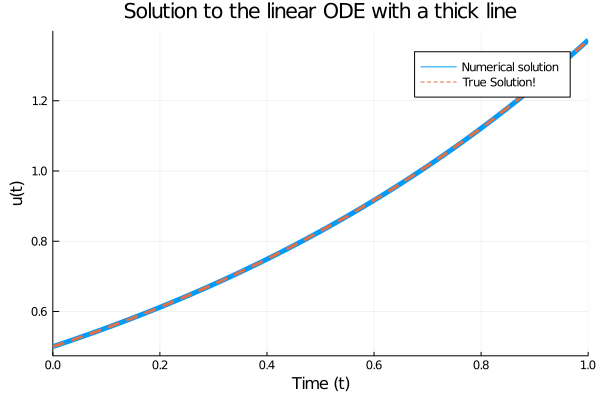

In [5]:
using Plots
plot(sol,linewidth=5,title="Solution to the linear ODE with a thick line",
     xaxis="Time (t)",yaxis="u(t)",label="Numerical solution")
plot!(sol.t, t->0.5*exp(1.01t),lw=3,ls=:dash,label="True Solution!")

And that's all neat. On to the main course!

# Once more, with uncertainty!

For convenience (and practice!), we'll wrap our previous computation in a function:

In [6]:
function compute(α, u0, tspan)
    f(u, p, t) = α * u
    noisy_prob = ODEProblem(f, u0, tspan)
    noisy_sol = solve(noisy_prob, Tsit5(), reltol=1e-8, abstol=1e-8)
    noisy_sol             # Julia returns the last statement in a function
end

compute (generic function with 1 method)

And now we'll add Measurements.jl and input a slightly noisy value for the $\alpha$ constant, using $\pm$ (typed in Jupyter as `\pm<TAB>`):

In [7]:
using Measurements
noisy_sol =compute(1.01 ± 0.1,
    1/2 ± 0,  # this had to be the same type, or we'd get an exception:
    (0.0, 1.0)
    )

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 17-element Array{Float64,1}:
 0.0
 0.012407826196308189
 0.042501278333560696
 0.0817804940926822
 0.12887384498704435
 0.18409796286152927
 0.24627457447456758
 0.31479297816557983
 0.3885963515160237
 0.4668617724420117
 0.5487161305960653
 0.6334346972152323
 0.7203630000154827
 0.808957991167541
 0.8987655040395068
 0.9894161889652783
 1.0
u: 17-element Array{Measurement{Float64},1}:
     0.5 ± 0.0
 0.50631 ± 0.00063
  0.5219 ± 0.0022
  0.5431 ± 0.0044
  0.5695 ± 0.0073
   0.602 ± 0.011
   0.641 ± 0.016
   0.687 ± 0.022
    0.74 ± 0.029
   0.801 ± 0.037
    0.87 ± 0.048
   0.948 ± 0.06
   1.035 ± 0.075
   1.132 ± 0.092
    1.24 ± 0.11
    1.36 ± 0.13
    1.37 ± 0.14

And you can already see the uncertainties propagate onwards! The further in time, the more effect that slight discrepancy in the value of $\alpha$ (or $R_0$, these days...) will have. That makes sense!

The amazing thing is that I can stick `noisy_sol` right into the `plot` command of Plots.jl:

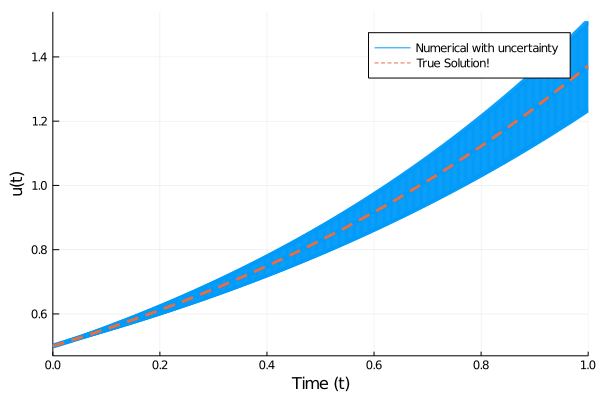

In [8]:
plot(noisy_sol, lab="Numerical with uncertainty",
     linewidth=5, xaxis="Time (t)",yaxis="u(t)",
)
plot!(sol.t, t->0.5*exp(1.01t),lw=3,ls=:dash,label="True Solution!")

Just like that! And that's just a little magical to me.

We can also put an uncertainty on the initial condition - we rarely know those with perfect accuracy.

In [9]:
noisy_sol =compute(1.01,   # interestingly the constant can be a "precise" float
    1/2 ± 0.3,
    (0.0, 1.0)
    )

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 17-element Array{Float64,1}:
 0.0
 0.012407826196308189
 0.042501278333560696
 0.0817804940926822
 0.12887384498704435
 0.18409796286152927
 0.24627457447456758
 0.31479297816557983
 0.3885963515160237
 0.4668617724420117
 0.5487161305960653
 0.6334346972152323
 0.7203630000154827
 0.808957991167541
 0.8987655040395068
 0.9894161889652783
 1.0
u: 17-element Array{Measurement{Float64},1}:
  0.5 ± 0.3
 0.51 ± 0.3
 0.52 ± 0.31
 0.54 ± 0.33
 0.57 ± 0.34
  0.6 ± 0.36
 0.64 ± 0.38
 0.69 ± 0.41
 0.74 ± 0.44
  0.8 ± 0.48
 0.87 ± 0.52
 0.95 ± 0.57
 1.04 ± 0.62
 1.13 ± 0.68
 1.24 ± 0.74
 1.36 ± 0.81
 1.37 ± 0.82

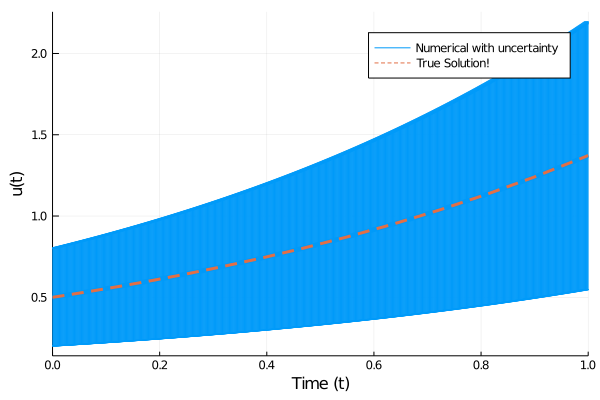

In [10]:
plot(noisy_sol, lab="Numerical with uncertainty",
     linewidth=5, xaxis="Time (t)",yaxis="u(t)",
)
plot!(sol.t, t->0.5*exp(1.01t),lw=3,ls=:dash,label="True Solution!")

We can also combine the uncertainties to our heart's content! I'm choosing to run this with a very large uncertainty on the constant, to illustrate the point.

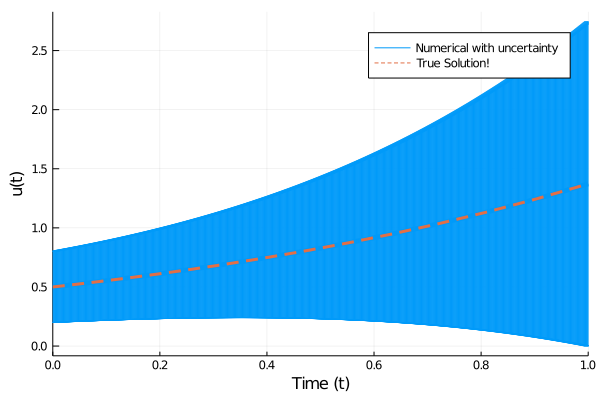

In [11]:
noisy_sol =compute(1.01 ± 0.8,
    1/2 ± 0.3,
    (0.0, 1.0)
    )
plot(noisy_sol, lab="Numerical with uncertainty",
     linewidth=5, xaxis="Time (t)",yaxis="u(t)",
)
plot!(sol.t, t->0.5*exp(1.01t),lw=3,ls=:dash,label="True Solution!")

# Composability

And here's the point I wanted to make.

Nobody wrote uncertainty support for DifferentialEquations.jl. [Here's a search for references to measurements in that package - nil.](https://github.com/SciML/DifferentialEquations.jl/search?q=measurements&unscoped_q=measurements) It just popped out of Julia's composable type system.

The plotting part is admittedly custom and can be found [here](https://github.com/JuliaPhysics/Measurements.jl/search?q=plots&unscoped_q=plots). But still - imagine, in Python, combining `scipy.integrate.odeint`, `uncertainties` and maybe even `astropy.units` or `pint`, or what have you.

Here it "just works". Magic! 

Actually, speaking of unit packages...

In [12]:
using Unitful
1u"s" ^ 3

1 s^3

And if we try...

In [13]:
0.5u"m" ± 40u"cm"

0.5 ± 0.4 m

Well, maybe...

In [14]:
1.01u"1/s" ± 0.1u"1/s"

1.01 ± 0.1 s^-1

Maybe, maybe, maybe...

In [15]:
noisy_sol =compute(1.01u"1/s",
    0.5u"m" ± 40u"cm",  # I had to cheat a little here
    (0.0u"s", 1.0u"s"),
    )

MethodError: MethodError: no method matching Float64(::Measurement{Float64})
Closest candidates are:
  Float64(::Real, !Matched::RoundingMode) where T<:AbstractFloat at rounding.jl:200
  Float64(::T) where T<:Number at boot.jl:715
  Float64(!Matched::Int8) at float.jl:60
  ...

Aaaaand I guess that's our weekly reminder that Julia's multiple dispatch system is **not** magic, and doesn't solve every problem for us!

If you do have an idea about how to actually run that, please say so in the comments! In the meantime, I hope you enjoyed this short read! :)